* Bailey Wang (914955801)
* Kevin Chu (913077890)
* Jiannan Zhao (913038538)

## Introduction

* We obtained this dataset from https://github.com/jamesqo/gun-violence-data. 
* The creator of the dataset webscraped https://www.gunviolencearchive.org/
* There are 2 missing entries in this dataset, the Las Vegas Mass Shooting and https://www.gunviolencearchive.org/incident/1081885. 


* For our project, we decided to use a dataset we found online about all the gun violence incidents from 2013 to (March) 2018. We decided to use only 2014 and onwards because the data recorded for 2013 is not comprehensive and as a result a lot of observations were missing. We chose to work on this project due to the increased number of mass shootings in recent news. In this project, first we analyzed the data and visualized what we felt were important features in the dataset, second we fit models for prediction, and third we applied time series analysis to the dataset.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
### Data 
import pandas as pd
import numpy as np
from collections import Counter

### Plots
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import folium
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Models
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from scipy import stats
from fbprophet import Prophet

### Others 
import os 
import json
import urllib.request
from os import path
import warnings
import calendar

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [3]:
data = pd.read_csv('stage3.csv')
data = data[data['date'] >= '2014-01-01']            # We only collect data starting from 2014
data = data.reset_index(drop = True)

## Data Description
The data contains 22 variables(excluding varibales such as weblinks). The description of features is shown below.

Characteristics of Gun Violence
* incident_id: ID for incident (gun violence archive)
* date: data of incident occurence
* state: state of incident 
* city_or_county: city of incident 

Variables we are going to predict
* n_killed: number of people killed 
* n_injured: number of people injured

Locations and Guns details of Gun Violence
* congressional_district: number of district
* incident_characteristics: list of incident characteristics 
* location_description: description of location where incident took place
* state_house_district: number of the state house district
* state_senate_district: number of the senate house district
* latitude: latitude of incident
* longitude: longitude of incident 
* gun_stolen: Unknown or Stolen
* gun_type: desciption of gun type 
* n_guns_involved: number of guns involved in incident

Details of Gun Violence
* participant_age: age of people involved in incident 
* participant_age_group: age group of people involved in incident
* participant_gender: gender of people involved in incident
* participant_name: name of people involved in incident
* participant_status: status of people involved in incident
* participant_type: type of people involved in incident

## **Part I**
### **Data Analysis & Visualization**

In [4]:
def data_clean(data):
    """
    Cleans the data using split and replace to make the data easier to work with. 
    
    Parameters:
    -----------
    data : str
    
    Returns
    -----------
    dataframe
    """

    cleaned_data = []
    data = data.split('||')
    data = [i.replace('::', ':') for i in data]
    data = [(i.split(':')) for i in data]
    for i in range(len(data)):
        cleaned_data.append(data[i][-1])
        return(cleaned_data)

In [5]:
def incident_function(x):
    """
    Cleans the data using split and replace to get rid of non-useful text. 
    This is used for special cases where the there are only "|" in the string.
    
    Parameters:
    -----------
    x : str
    
    Returns
    -----------
    series
    """

    incident_list = "||".join(data[x].dropna()).split("||")
    incident_list_2 = "|".join(incident_list).split("|")
    incident_list_3= pd.Series( ( x for x in incident_list_2))
    return(incident_list_3)

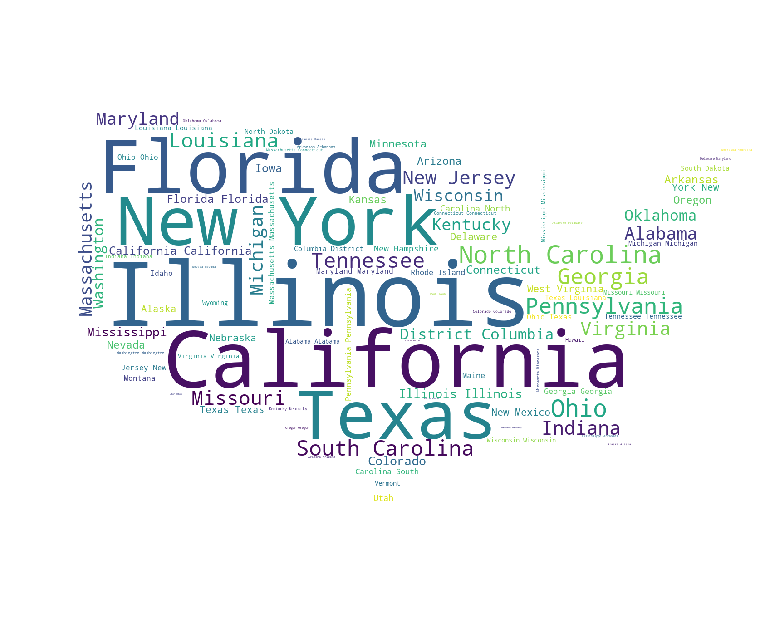

In [6]:
d = path.dirname('usa.jpg')
usa = np.array(Image.open(path.join(d, "usa.jpg")))
wordcloud = WordCloud(background_color = 'white',width = 1000, height = 860, margin = 2,
                      mask = usa).generate(' '.join(data.state))
plt.rcParams['figure.figsize'] = [13, 13]
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* The plot above is a simple wordcloud of the states recorded in the dataset. We can see that the states with the most incident counts are Illinois, California, Florida, New York, and Texas

In [7]:
weekday_dict = dict(enumerate(calendar.day_name)) #Dictionary of weekdays for mapping values
month_dict = dict(enumerate(calendar.month_name)) #Dictionary of months for mapping values

data['year'] = pd.to_datetime(data['date']).dt.year #Separate year, month, day into their own 
data['month'] = pd.to_datetime(data['date']).dt.month.map(month_dict) #columns
data['day'] = pd.to_datetime(data['date']).dt.weekday.map(weekday_dict)

map_data = pd.DataFrame({'killed':data.n_killed,'injured':data.n_injured,\
                        'lat':data.latitude,'lon':data.longitude,'state':data.state
                   })

index_old = data.index[data.year !=2018].tolist()
dat = map_data.loc[index_old].dropna().reset_index(drop = True)

### incidents counts of every states 
map_data.state = map_data.state.replace(['Alabama','Alaska','Arizona','Arkansas','California','Colorado', 'Connecticut',
                   'Delaware','District of Columbia','Florida','Georgia','Hawaii','Idaho','Illinois','Iowa','Indiana','Kansas',
                  'Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota',
                  'Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
                  'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania',
                  'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia',
                  'Washington','West Virginia','Wisconsin','Wyoming'],
                  ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IA','IN','KS','KY','LA','ME','MD','MA',
                  'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
                  'TX','UT','VT','VA','WA','WV','WI','WY'])

killed_vic= np.zeros(51)
states = map_data.state.unique()
for i in range(51):
    e = map_data.index[map_data.state == states[i]]
    killed_vic[i] = dat.killed[e].sum()
maps = pd.DataFrame({'states':states,'killed':killed_vic})

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
response = urllib.request.urlopen(url)
d = response.read()
text = d.decode('utf-8')

map_2 =folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data = text,
    name='choropleth',
    data=maps,
    columns=['states', 'killed'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(map_2)

folium.LayerControl().add_to(map_2)
map_2

* The states with the highest homicide rates are California, Texas, and Illinois.
* California increased the number of sales for firearms by a large margin. The increased in fear due to the number of gun related violence caused for the mass purchase for firearms. Even with these purchases, the gun related kills are actually coming from suicides rather than homicides.
* However unlike the other states, Texas continues to decrease the amount of gun control laws. Texas contains the most firearm retailers. Most households contain firearms which increases the risks of homicides and suicides. 

* Most of the East coast contains median-high amounts of homicide with New York, Georgia, and Florida with the highest. The East Coast homicide rate could be inferred as mostly gang involved crimes, thus the area is in a dense area with high poverty rates.
* For Florida, there is no ban on automatic rifles. These weapons allow the suspect to attack people more rapidly. In both Florida and Georgia have the "Stand your Ground" laws which increased the rates of homicides as more individals are using firearms in the act of self-defense.

https://www.sacbee.com/news/local/crime/article177540461.html
https://www.txgunsense.org/gun-violence-facts

In [8]:
### Top ten dangerous states and cities/counties
top_10_states = data['state'].value_counts()[:10].index.tolist() #subset by top 10 staes
dangerous_states = data[data['state'].isin(top_10_states)]
states_n_injured = dangerous_states.groupby('state')['n_injured'].sum() #Find sum for injured
states_n_killed = dangerous_states.groupby('state')['n_killed'].sum() #Find sum for killed

top_10_cities = data['city_or_county'].value_counts()[:10].index.tolist() #subset by top 10 cities
dangerous_cities = data[data['city_or_county'].isin(top_10_cities)]
cities_n_injured = dangerous_cities.groupby('city_or_county')['n_injured'].sum()
cities_n_killed = dangerous_cities.groupby('city_or_county')['n_killed'].sum()

In [9]:
trace1 = go.Bar(
    x = data['city_or_county'].value_counts()[:10].index.tolist(),
    y = data['city_or_county'].value_counts()[:10],
    name = 'city or county'
)

trace2 = go.Bar(
    x = dangerous_cities.groupby('city_or_county')['n_killed'].sum().index.tolist(),
    y = cities_n_injured,
    name = 'cities_n_injured'
)

trace3 = go.Bar(
    x = dangerous_cities.groupby('city_or_county')['n_killed'].sum().index.tolist(),
    y = cities_n_killed,
    name = 'cities_n_killed'
)

trace4 = go.Bar(
    x = data['state'].value_counts()[:10].index.tolist(),
    y = data['state'].value_counts()[:10],
    name = 'states'
)

trace5 = go.Bar(
    x = dangerous_states.groupby('state')['n_killed'].sum().index.tolist(),
    y = states_n_injured,
    name = 'states_n_injured'
)

trace6 = go.Bar(
    x = dangerous_states.groupby('state')['n_killed'].sum().index.tolist(),
    y = states_n_killed,
    name = 'states_n_killed'
)

fig = tools.make_subplots(rows = 2, cols = 1, subplot_titles = ('Top 10 Dangerous Cities/Counties', 
                                                               'Top 10 Dangerous States'))
fig.append_trace(trace4, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 1)

fig['layout'].update(height = 700, width = 950)
py.offline.iplot(fig)


This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



* Chicago
Baltimore
Washington

* Compared to the other cities, Chicago has an extremely high population. Chicago has a higher homicide rate compared to other cities, however it does not have the highest crime rate.
Baltimore's homicide rate is incredibly high, however, the concentration is located in a dense area. The crime rates between gun violence and drug-involved are entwined with each other including gang crimes.
In Washington it appears that most of the crime happens in cities with low populations. The cities with small populations will have a crime happen for 10 per 100000. The crime rate for Washington is between homicide and property theft.
New Orleans had the highest crime rate compared to the national average.
Philadephia has a higher homicide rates related to drug-involved. Similarly, the crime rates concentrates in one area. The majority of homicides resulted from arguments and drug-involved.

In [10]:
data['location_description']= data['location_description'].str.replace('WalMart', 'Walmart')
location_value = data['location_description'].dropna()
location_value_list = location_value.value_counts()[:11].tolist()
location_value_list = location_value_list[:1] + location_value_list[2:11]

layout = go.Layout(
    title = 'Most Common Locations',
    yaxis = dict(title = 'Location Counts'),
    xaxis = dict(title = 'Location')
)

trace1 = go.Bar(
    x = location_value.value_counts()[:1].index.tolist() + location_value.value_counts()[2:11].index.tolist(),
    y = location_value_list
)

fig = go.Figure(data = [trace1], layout = layout)
py.offline.iplot(fig)

* From the plot we can see the most common locations where gun violence incidents occured. It is interesting that Walmart has such a high occurence count but upon further research, this is due to the corporations cost cutting policies. There is a lack of workers and greeters near the entrance which make it easier for people to bring guns into the store. 
* 7-Elevens appearance on the plot can also be explained by the lack of employees in the store. 7-Elevens also generally operate 24/7 and they also sell alcohol and such, so it is more likely for people to enter the store at night with criminal intent. 
* Motel6 has low rates and low security. It is an easy target for criminals to loiter around. There is also a lack of awareness for who enters and leaves the grounds. They are also non-close gated communities which allows for easy access into the rooms.

In [11]:
data_2014 = data.copy()[data['date'].str.contains('2014')]
data_2015 = data.copy()[data['date'].str.contains('2015')]
data_2016 = data.copy()[data['date'].str.contains('2016')]
data_2017 = data.copy()[data['date'].str.contains('2017')]
data_2018 = data.copy()[data['date'].str.contains('2018')]

years = np.arange(1, 5)
year_total_incidents = data['year'].value_counts(sort = [True], ascending = [True]).tolist()
year_total_incidents = year_total_incidents[1:] + [year_total_incidents[0]]
year_total_incidents = year_total_incidents[:4]

year_slope, year_intercept, year_r_value, year_p_value, year_std_err = stats.linregress(years, year_total_incidents)
year_line = year_slope * years + year_intercept

layout = go.Layout(
    title = 'Incident Counts Per Year',
    yaxis = dict(title = 'Incident Counts'),
    xaxis = dict(title = 'Year')
)

trace1 = go.Bar(
    x = data['year'].value_counts().index.tolist()[:4],
    y = data['year'].value_counts()[:4],
    name = 'Incident Counts'
)

trace2 = go.Bar(
    x = data['n_killed'].groupby(data['year']).sum().index.tolist()[:4],
    y = data['n_killed'].groupby(data['year']).sum()[:4],
    name = 'n_killed'
)

trace3 = go.Bar(
    x = data['n_injured'].groupby(data['year']).sum().index.tolist()[:4],
    y = data['n_injured'].groupby(data['year']).sum()[:4],
    name = 'n_injured'
)

trace4 = go.Scatter(
    x = [2014, 2015, 2016, 2017],
    y = year_line,
    name = 'regression line 2014-2017'
)

fig = go.Figure(data = [trace1, trace2, trace3, trace4], layout = layout)
py.offline.iplot(fig)

* From the plot, we can see that the total number of incidents increase each year. We can also see that the total number of incidents increased the most from years 2015 to 2016. The total number of injured and killed also rise as years pass. This plot doesn't include the data from 2018 because the 2018 data is only recorded up to March, but from the plot we can expect the total number of incidents in 2018 to be higher than 2017. 

In [12]:
### Incidents Counts Per months to year
month_counts_total = Counter(data['month'])
month_counts_2014 = Counter(data_2014['month'])
month_counts_2015 = Counter(data_2015['month'])
month_counts_2016 = Counter(data_2016['month'])
month_counts_2017 = Counter(data_2017['month'])

months = np.arange(1, 13)
month_slope, month_intercept, month_r_value, month_p_value, month_std_err = stats.linregress(months, 
                                                list(month_counts_total.values()))
month_line = month_slope * months + month_intercept

In [13]:
layout = go.Layout(
    barmode = 'group',
    title = 'Incident Counts Per Month According To Year',
    yaxis = dict(title = 'Incident Counts'),
    xaxis = dict(title = 'Month')
)

trace1 = go.Bar(
    x = list(month_counts_total),
    y = list(month_counts_total.values()),
    name = 'total'
)

trace2 = go.Bar(
    x = list(month_counts_total),
    y = list(month_counts_2014.values()),
    name = '2014'
)

trace3 = go.Bar(
    x = list(month_counts_total),
    y = list(month_counts_2015.values()),
    name = '2015'
)

trace4 = go.Bar(
    x = list(month_counts_total),
    y = list(month_counts_2016.values()),
    name = '2016'
)

trace5 = go.Bar(
    x = list(month_counts_total),
    y = list(month_counts_2017.values()),
    name = '2017'
)

trace6 = go.Scatter(
    x = list(month_counts_total),
    y = month_line,
    name = 'regression line'
)

fig = go.Figure(data = [trace1, trace2, trace3, trace4, trace5, trace6], layout = layout)
py.offline.iplot(fig)

* From this plot we can see that the total # of incidents per month goes down as it gets later into the year. We can also see that November and December has the lowest total incident counts. This can be attributed to it being the end of the year and being the time of year where most people celebrate (i.e. Thanksgiving, Christmas, Hanukkah). January is the month with the highest number of incidents and this is maybe because people are out drinking on New Years and as a result they are more likely to be violent.

In [14]:
#Data for pie chart for gun type distribution

data['gun_type'] = data['gun_type'].fillna('Unknown').apply(lambda x: data_clean(x))
gun_list = []

for i in range(len(data['gun_type'])):
    for j in range(len(data.loc[i, 'gun_type'])):
        if data.loc[i, 'gun_type'][j] != 'Unknown':
            gun_list.append(data.loc[i, 'gun_type'][j])
            
unique_guns = list(set(gun_list))
guns_count = [0] * len(unique_guns)

for i in range(len(gun_list)):
    for j in range(len(unique_guns)):
        if unique_guns[j] == gun_list[i]:
            guns_count[j] += 1
            
gun_data = pd.DataFrame({'Gun': unique_guns, 'Counts': guns_count})
gun_data = gun_data.sort_values(['Counts'], ascending = False)

gun_map = {'Handgun': 'Handgun', '25 Auto': 'Handgun', '45 Auto': 'Handgun', '44 Mag': 'Handgun',
           '357 Mag': 'Handgun', '9mm': 'Handgun', '32 Auto': 'Handgun', '38 Spl': 'Handgun',
           '40 SW': 'Handgun', '10mm': 'Handgun', '380 Auto': 'Handgun',
           
           '7.62 [AK-47]': 'Rifle', '22 LR': 'Rifle', '30-30 Win': 'Rifle', 'Rifle': 'Rifle',
           '223 Rem [AR-15]': 'Rifle', '300 Win': 'Rifle', '308 Win': 'Rifle', '30-06 Spr': 'Rifle',
           
           'Shotgun': 'Shotgun', '28 gauge': 'Shotgun', '16 gauge': 'Shotgun', '20 gauge': 'Shotgun',
           '12 gauge': 'Shotgun', '410 gauge': 'Shotgun',
           
           'Other': 'Other'
          }

temp_gun_type = pd.DataFrame({'gun_list': gun_list})
temp_gun_type['gun_list'] = temp_gun_type['gun_list'].map(gun_map)

gun_type_cleaned_labels = temp_gun_type['gun_list'].value_counts().index.tolist()
gun_type_cleaned_values = temp_gun_type['gun_list'].value_counts()
gun_type_cleaned_colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

In [15]:
trace1 = go.Pie(
    titlefont = dict(size = 15),
    labels = gun_type_cleaned_labels,
    values = gun_type_cleaned_values,
    hoverinfo = 'label+percent',
    textinfo = 'value',
    textfont = dict(size = 20),
    marker = dict(colors = gun_type_cleaned_colors, 
                 line = dict(color = '#000000', width = 2))
)

layout = go.Layout(
    title = 'Distribution of Types of Guns Used',
)

fig = go.Figure(data = [trace1], layout = layout)
py.offline.iplot(fig)

* From the plot, we can see that the most common type of guns used are handguns followed by rifles and shotguns. Handguns are especially prevalent due to how easy it is to hide one when walking around. Rifles and shotguns are lower probably because it is harder to carry one around without being noticed. 

In [16]:
#Data for Pie chart about number of guns

data_n_guns_drop = data.copy()
data_n_guns_drop = data_n_guns_drop.dropna(subset = ['n_guns_involved'])
data_n_guns_drop = data_n_guns_drop.reset_index(drop = True)

for i in range(len(data_n_guns_drop)):
    if data_n_guns_drop.loc[i, 'n_guns_involved'] >= 5:
        data_n_guns_drop.loc[i, 'n_guns_involved'] = '5+'
        
data_n_guns_drop['n_guns_involved'] = data_n_guns_drop['n_guns_involved'].astype(str)

n_guns_labels = data_n_guns_drop['n_guns_involved'].value_counts().index.tolist()
n_guns_values = data_n_guns_drop['n_guns_involved'].value_counts()
n_guns_colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1', '#e377c2']

In [17]:
trace1 = go.Pie(
    titlefont = dict(size = 15),
    labels = n_guns_labels,
    values = n_guns_values,
    hoverinfo = 'label+percent',
    textinfo = 'value',
    textfont = dict(size = 20),
    marker = dict(colors = n_guns_colors, 
                line = dict(color = '#000000', width = 2))
)

layout = go.Layout(
    title = 'Gun Counts Per Incident Distribution',
    titlefont = dict(size = 25)
)

fig = go.Figure(data = [trace1], layout = layout)
py.offline.iplot(fig)

http://www.pewresearch.org/fact-tank/2017/06/22/key-takeaways-on-americans-views-of-guns-and-gun-ownership/

* 91%  1 gun
5% 2 gun
< 2% for guns 3,4,5 and 5+

* The rise of gun crimes caused America to increase their policies on gun ownership. However, even when these laws in placed, there are still many criminations with guns from stealing.
Majority of men own a gun. However, from this study it shows that most urban areas own guns, compared to the dangerous city/county statistic.
Most city gun owners cite the usage of guns as protection, while the rural area cite usage of guns for hunting.
The most popular choice for guns is the handgun. 

In [18]:
#Data for participants' status 

data['participant_status'] = data['participant_status'].fillna('Unknown').apply(lambda x: data_clean(x))
status_list = []

for i in range(len(data['participant_status'])):
    for j in range(len(data.loc[i, 'participant_status'])):
        if data.loc[i, 'participant_status'][j] != 'Unknown':
            status_list.append(str(data.loc[i, 'participant_status'][j]))
            
unique_status = list(sorted(set(status_list)))
status_count = [0] * len(unique_status)

for i in range(len(status_list)):
    for j in range(len(unique_status)):
        if unique_status[j] == status_list[i]:
            status_count[j] += 1
            
status_data = pd.DataFrame({'Status' : unique_status, 'Counts' : status_count})

status_list_1="[".join(str(x) for x in data['participant_status']).split("[")
status_list_1="]".join(str(x) for x in status_list_1).split("]")
status_list_1= [i.replace(',','' ) for i in status_list_1]
status_list_2="'".join(str(x) for x in status_list_1).split("'")
status_list_3=pd.Series(status_list_2)

In [19]:
status_labels = ['Unharmed','Injured','Arrested','Killed']
status_values = [188170,116580,99075, 59629]
colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

trace = go.Pie(
    labels = status_labels,
    values = status_values,
    hoverinfo = 'label+percent',
    textinfo = 'value',
    textfont = dict(size=20),
    marker = dict(colors = colors, 
                line = dict(color='#000000', width=2))
)

layout = go.Layout(
    title = 'Counts of Status of People Involved'
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig)

25% injured
21% Arrested
13% killed
40% Unharmed

* Its surprising that the largest portion is unharmed. I think it's because most incidents that happen usually involve large public locations which increases the number of unharmed and injuried participants by a large margent. However, it appears that most incidents usually involve usually one victim.
* It makes sense that arrested is on the lower spectrum since majority of the incidents involve one suspect rather than multiple.

In [20]:
### Age distribution
data['participant_age'] = data['participant_age'].fillna('Unknown').apply(lambda x: data_clean(x))
data['participant_type'] = data['participant_type'].fillna('Unknown').apply(lambda x: data_clean(x))

age_list = []
suspect_age_list = []
victim_age_list = []

for i in range(len(data['participant_age'])):
    for j in range(len(data.loc[i, 'participant_age'])):
        if data.loc[i, 'participant_age'][j] != 'Unknown':
            age_list.append(float(data.loc[i, 'participant_age'][j]))
            
unique_ages = list(sorted(set(age_list)))
ages_count = [0] * len(unique_ages)

for i in range(len(age_list)):
    for j in range(len(unique_ages)):
        if unique_ages[j] == age_list[i]:
            ages_count[j] += 1
            
for i in range(len(data['participant_age'])):
    for j in range(len(data.loc[i, 'participant_age'])):
        if data.loc[i, 'participant_age'][j] != 'Unknown' and 'Suspect' in data.loc[i, 'participant_type'][j]:
            suspect_age_list.append(float(data.loc[i, 'participant_age'][j]))
            
suspect_unique_ages = list(sorted(set(suspect_age_list)))
suspect_ages_count = [0] * len(suspect_unique_ages)

for i in range(len(suspect_age_list)):
    for j in range(len(suspect_unique_ages)):
        if suspect_unique_ages[j] == suspect_age_list[i]:
            suspect_ages_count[j] += 1
            
for i in range(len(data['participant_age'])):
    for j in range(len(data.loc[i, 'participant_age'])):
        if data.loc[i, 'participant_age'][j] != 'Unknown' and 'Victim' in data.loc[i, 'participant_type'][j]:
            victim_age_list.append(float(data.loc[i, 'participant_age'][j]))
            
victim_unique_ages = list(sorted(set(victim_age_list)))
victim_ages_count = [0] * len(victim_unique_ages)          

for i in range(len(victim_age_list)):
    for j in range(len(victim_unique_ages)):
        if victim_unique_ages[j] == victim_age_list[i]:
            victim_ages_count[j] += 1

In [21]:
layout = go.Layout(
    title = 'Distribution of Ages Involved in Incidents',
    yaxis = dict(title = 'Counts'),
    xaxis = dict(title = 'Age', range = [0, 100])
)

trace1 = go.Line(
    x = unique_ages,
    y = ages_count,
    name = 'All Participants Age Distribution'
)

trace2 = go.Line(
    x = victim_unique_ages,
    y = victim_ages_count,
    name = 'Victims Age Distribution'
)

trace3 = go.Line(
    x = suspect_unique_ages,
    y = suspect_ages_count,
    name = 'Suspect Age Distribution'
)

fig = go.Figure(data = [trace1, trace2, trace3], layout = layout)
py.offline.iplot(fig)

* From the plot it seems that the most common ages to be involved in a gun violence incident is 18 and 19. It is also interesting to see that the most common age for a suspect to be involved in a gun violence incident is 18. This is usually the time in peoples' lives where they are lost and looking for direction. This combined with the added stress of other factors such as real world problems can explain why this age occurs so frequently. Also at this age, people are more likely to act more impulsively and are more likely to fail when it comes to determining risks and taking responsibility.

* https://abcnews.go.com/Technology/story?id=3943187&page=1

In [22]:
data['participant_gender'] = data['participant_gender'].fillna('Unknown').apply(lambda x: data_clean(x))
suspect_gender_list = []

for i in range(len(data['participant_gender'])):
    for j in range(len(data.loc[i, 'participant_gender'])):
        if data.loc[i, 'participant_gender'][j] != 'Unknown' and 'Suspect' in data.loc[i, 'participant_type'][j]:
            suspect_gender_list.append(data.loc[i, 'participant_gender'][j])

In [23]:
gender_labels = ['Male','Female']
gender_values = [suspect_gender_list.count('Male'), suspect_gender_list.count('Female')]
colors = ['light_blue', 'pink']

trace = go.Pie(
    labels = gender_labels,
    values = gender_values,
    hoverinfo = 'label+percent',
    textinfo = 'value',
    textfont = dict(size=20),
    marker = dict(colors = colors, 
                line = dict(color='#000000', width=2))
)

layout = go.Layout(
    title = 'Gender distribution of Suspects'
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig)

* 94.8% Male
* 5.19% Female

* Almost 95% of gun violence crimes are commited by men. This plot shows that men are more violent than women but why is that the case? Upon further research, one of the main things we found is that this could be a result of our culture. In the United States, men are often portrayed as strong in many different mediums and to many people guns are a representation of strength.

In [24]:
incident_list_3 = incident_function('incident_characteristics')

layout = go.Layout(
    title = 'Incident Status',
    yaxis = dict(title = 'Incident Counts'),
    xaxis = dict(title = 'Incident')
)

trace1 = go.Bar(
    x = incident_list_3.value_counts()[:10].index.tolist(),
    y = incident_list_3.value_counts()[:10]
)

fig = go.Figure(data = [trace1], layout = layout)
py.offline.iplot(fig)

* 93k shot wounded/injured
53k dead
44k non-shooting

* It is not surprising that the most incidents occurred are injury from gun shot. It also shows that there are other incidents committed with the use of gun such as possesionof guns and no injury with shots fired.

* 13k drive-by incident are low since they only occur in a concentrated area specfically gang areas. Therefore it can be assumed that most drive-by incidents occur in high gang related consentration which in relates involves police involvement and armed robbery.

* shots fired with no injuries has the 4th highest at 35k, shots fired relates to other gun related incidents like shots - wounded and shot - dead. Therefore, these incidents can be related in some sort of way.

* 17k drug involved crime, it could be that the legalization of marijuana will cut the number of drug related crimes. However, before 2018, there are still a lot of crimes related to drugs. It could be that drug related crimes involve arugments, roberies or retaliations determined by the police. Therefore, the drug related crimes are very subjective.

## Part II  Model Fit
* ####  Random Forest - Feature Importance 

    Frist step is measuring the variable importance in one dataset $D_{n} = {(X_{i},Y_{i})}^{N}_{i=1}$ to fit the random forest to the data.

     Then we are going to use the stepwise procedure to find the best linear regression model.

* #### Model Selection - Forward Regression & Backward Regression
    Linear Model   $\hat{Y_{i}} = \hat{\beta_{0}} + \hat{\beta_{1}}X_{i} + \hat{\beta_{2}}X_{i}+...$

    We are going to find the best linear model by comparing their AIC, BIC and R-squared values.
    
> $\bar{y} = \frac{1}{n}\sum(y_{i})$, $SS_{tot} = \sum_{i}(y_{i}-\bar{y})^2$, $SS_{reg} = \sum_{i}(f_{i}-\bar{y})^2$, $SS_{res} = \sum_{i}(y_{i}-f_{i})^2 = \sum_{i}(e_{i})^2$, $R^{2} = 1 - \frac{SS_{res}}{SS_{tot}}$ 

> $AIC$ = -2$\ln (L) + 2k$

> $BIC$ = -2$\ln(L) + \ln(n)k$

   $L$ is maximum value of the likelihood function for the model and k is the number of variables


* #### Variance of the Estimators
    Five Assumptions
    
>Assumption 1 Predictor is known. Either the vectors $x_{1},...,x_{n}$ are known ahead of time, or they
are the observed values of random vectors $X_{1},...,X_{n}$ on whose values we condition
before computing the joint distribution of $(Y_{1}, . . . , Y_{n})$.

>Assumption 2 Normality. For $i = 1,...,n$ the conditional distribution of $Y_{i}$ given the vectors
$x_{1},.., x_{n}$ is a normal distribution.

>Assumption 3 Linear Mean. There is a vector of parameters $\beta = (\beta_{0},...,\beta_{p-1})$such that the conditional
mean of Yi given the values x1, . . . , xn has the form $x_{i0}\beta_{0} + x_{i1}\beta_{1} + . . . + x_{ip−1}\beta_{p−1}$, for $i = 1,2,...,n$.

>Assumption 4 Commom Variance. There is a parameter $\sigma^2$ such that the conditional variance of Yi
given the values $x_{1},..., x_{n}$ is $\sigma^2$ for $i = 1,..., n$.

>Assumption 5 Independence. The random variables $Y_{1},..., Y_{n}$ are independent given the observed $x_{1},...,x_{n}$.

$Var(\hat{\beta)} = E[\hat{\beta} - E(\hat{\beta})][\hat{\beta} - E(\hat{\beta})]^{'} = \sigma^2[X^{'}X]^{-1}$

* #### MSE of the Prediction 

    $E[(\hat{Y}-Y)^2]$ = $\sigma^2[1+\frac{1}{n}+\frac{(x-\bar{x})^2}{S_{x}^2}]$, $X$ is the new data

    $S^2_{X} = \sum_{i=1}^{i=n}(X_i - \bar{X})^2$

In [25]:
### Data for linear model
Dat = pd.DataFrame({'killed':data.n_killed,'injured':data.n_injured,'guns':data.n_guns_involved,\
                    'year':data.year,'month':data.month,'day':data.day,'lat':data.latitude,'lon':data.longitude,
                    'house_dist':data.state_house_district,'senate_dist':data.state_senate_district,'state':data.state
                   })
Dat.month= Dat.month.replace(['January','February','March','April','May','June','July','August','September','October','November','December'],[1,2,3,4,5,6,7,8,9,10,11,12])
Dat.day = Dat.day.replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

index_old = data.index[data.year !=2018].tolist()
dat = Dat.loc[index_old].dropna().reset_index(drop = True)

Text(0.5, 0, 'Relative Importance')

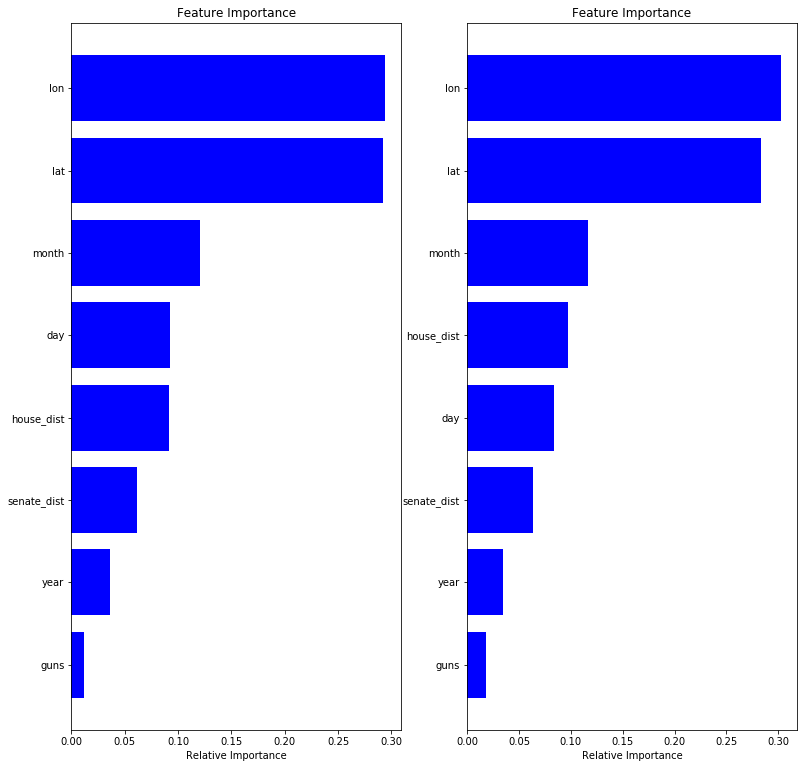

In [26]:
### linear model
X = dat.iloc[:,2:-1]                     ### Observations
Y1= np.cbrt(dat.killed)                  ### train data of number of killed transformed by cube root
Y2= np.cbrt(dat.injured)                 ### train data of number of injured transformed by cube root
rf1 = RandomForestRegressor()
rf2 = RandomForestRegressor()
rf1.fit(X,Y1)
rf2.fit(X,Y2)
names = np.array(list(dat)[2:-1])
importance1 = rf1.feature_importances_
ind1 = np.argsort(importance1)
plt.subplot(1, 2, 1)
plt.barh(range(len(ind1)), importance1[ind1], color='b', align='center')
plt.title('Feature Importance')
plt.yticks(range(len(ind1)), [names[i] for i in ind1])
plt.xlabel('Relative Importance')
plt.subplot(1, 2, 2)
importance2 = rf2.feature_importances_
ind2 = np.argsort(importance2)
plt.barh(range(len(ind2)), importance2[ind2], color='b', align='center')
plt.title('Feature Importance')
plt.yticks(range(len(ind2)), [names[i] for i in ind2])
plt.xlabel('Relative Importance')

* From the two plots shown above, we can see that the most important factors for prediction of n_killed and n_injured is longitude and latitude. 

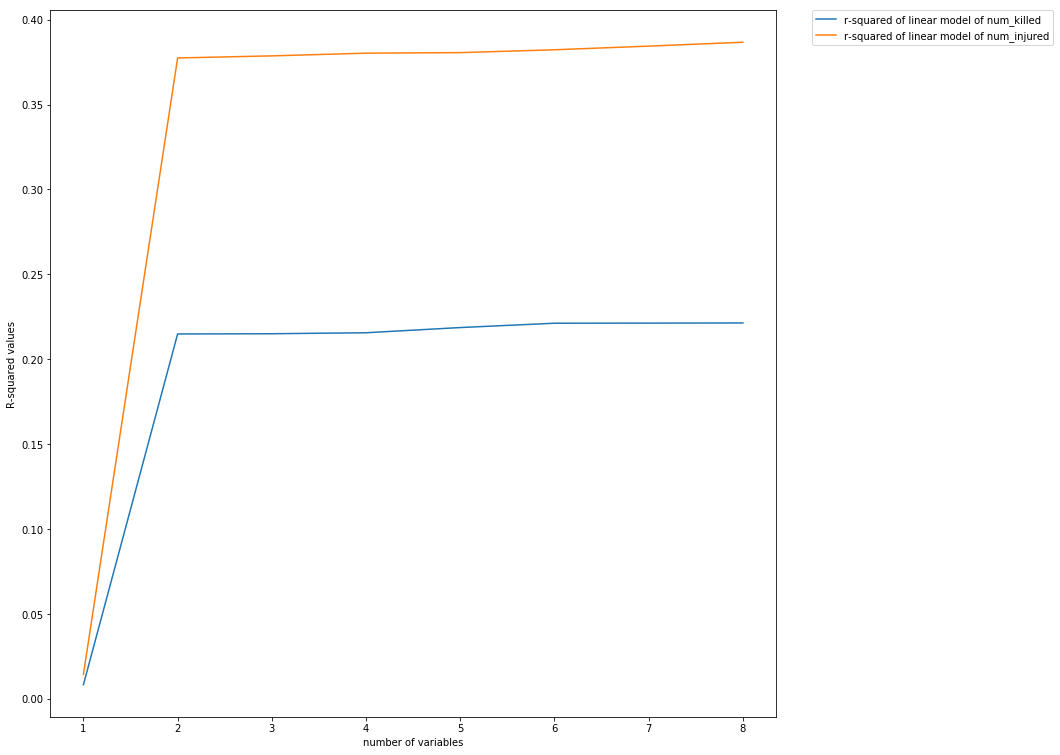

In [27]:
### Model Selection 
r1 = np.zeros(8)          ### R-squared about the model of number of killed
for i in range(3,11):
    n = dat.iloc[:,2:i]
    r1[i-3] = sm.OLS(Y1,n).fit().rsquared.tolist()
r2 = np.zeros(8)

for i in range(3,11):     ### R-squared about the model of number of injured
    n = dat.iloc[:,2:i]
    r2[i-3] = sm.OLS(Y2,n).fit().rsquared.tolist()
plt.plot(range(1,9),r1,label = 'r-squared of linear model of num_killed')
plt.plot(range(1,9),r2,label = 'r-squared of linear model of num_injured')
plt.xlabel('number of variables')
plt.ylabel('R-squared values')
#plt.legend('r1','r2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

model1 = sm.OLS(Y1,X).fit()                 ### linear regression of number of killed
model1  
model2 = sm.OLS(Y2,X).fit()                 ### linear regression of number of injured
model2

* Whether from forward or backward direction, when the model includes all features, it has the smallest value of AIC and BIC and highest R-squared. 

In [28]:
### prediction of 2018 first quarter by linear regression 
num_killed = []          ### actual number of people killed starting 2014 to 2017
num_injured = []         ### actual number of people killed starting 2014 to 2017
for i in range(2014,2018):
    for j in range(1,13):
        w = dat.index[(dat.year == i) & (dat.month == j)].tolist()
        num_killed.append(sum(dat.killed[w]))
        num_injured.append(sum(dat.injured[w]))
        
killed_2018 = []         ### actual people killed in 2018 first quarter 
injured_2018 = []        ### actual people injured in 2018 first quarter 
for i in range(3):   
    w = Dat.index[(Dat.year == 2018) & (Dat.month == i)].tolist()
    killed_2018.append(sum(Dat.killed[w]))
    injured_2018.append(sum(Dat.injured[w]))

index_new = Dat.index[Dat.year==2018].tolist()
X_new = Dat.loc[index_new].dropna().reset_index(drop = True)
X_new = X_new.iloc[:,2:-1]
predic_Y1 = model1.predict(X_new)           ### prediction of people killed in 2018 first quarter
predic_Y2 = model2.predict(X_new)           ### prediction of people injured in 2018 first quarter
linear_predic_total_1 = sum(predic_Y1)      
linear_predic_total_2 = sum(predic_Y2)
error_1 = abs(linear_predic_total_1-sum(killed_2018))/(sum(killed_2018))
error_2 = abs(linear_predic_total_2-sum(injured_2018))/(sum(injured_2018))
print ('The prediction of the number of people killed in 2018 first quarter is',round(linear_predic_total_1))
print ('The prediction of the number of people injured in 2018 first quarter is',round(linear_predic_total_2))
print ('The actual number of people killed in 2018 first quarter is',sum(killed_2018))
print ('The actual number of people injured in 2018 first quarter is',sum(injured_2018))
print ('The error of linear model of people killed in 2018 first quarter is',round(error_1,2))
print ('The error of linear model of people killed in 2018 first quarter is',round(error_2,2))

The prediction of the number of people killed in 2018 first quarter is 2220
The prediction of the number of people injured in 2018 first quarter is 3816
The actual number of people killed in 2018 first quarter is 2415
The actual number of people injured in 2018 first quarter is 4078
The error of linear model of people killed in 2018 first quarter is 0.08
The error of linear model of people killed in 2018 first quarter is 0.06


(-1.5, 60.0, -49.650000000000006, 2714.65)

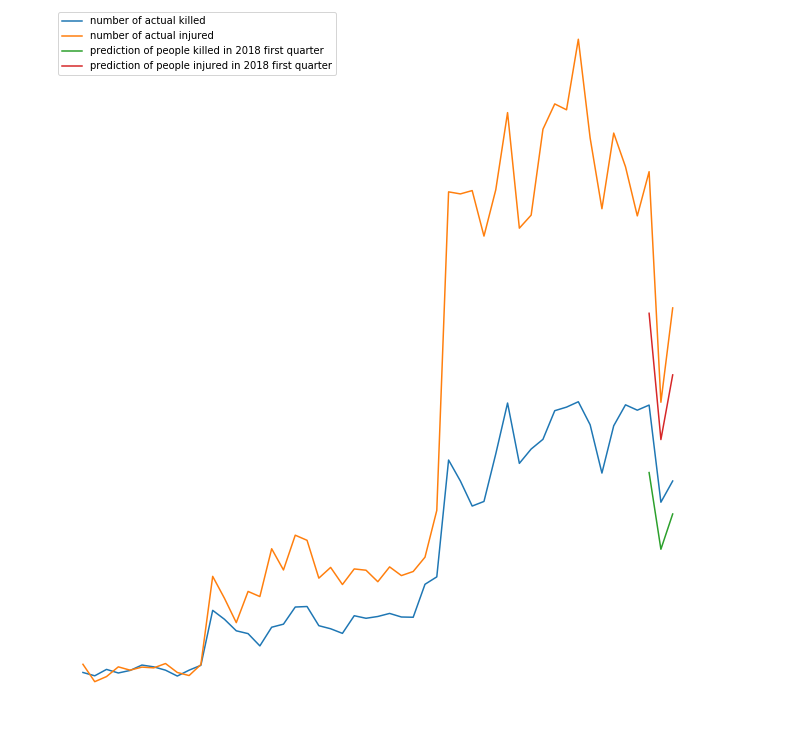

In [29]:
### plots of original data of number of killed or injured compared with the prediction in 2018 first quarter
test = Dat.loc[index_new].dropna().reset_index(drop = True)
test_Y1 = test.killed             ### original data of num of people killed in 2018 first quarter
test_Y2 = test.injured            ### original data of num of people injured in 2018 first quarter
index_2018_1 = test.index[test.month==1].tolist()
index_2018_2 = test.index[test.month==2].tolist()
index_2018_3 = test.index[test.month==3].tolist()
T_killed = num_killed + [sum(test.killed[index_2018_1]),sum(test.killed[index_2018_2]),sum(test.killed[index_2018_3])]
T_injured = num_injured + [sum(test.injured[index_2018_1]),sum(test.injured[index_2018_2]),sum(test.injured[index_2018_3])]

### predicted number of people killed or injured in 2018 first quarter per month
Train_killed = [round(sum(predic_Y1[index_2018_1])),round(sum(predic_Y1[index_2018_2])),round(sum(predic_Y1[index_2018_3]))]
Train_injured = [round(sum(predic_Y2[index_2018_1])),round(sum(predic_Y2[index_2018_2])),round(sum(predic_Y2[index_2018_3]))]

plt.plot(list(range(1,52)),T_killed,label = 'number of actual killed')
plt.plot(list(range(1,52)),T_injured,label = 'number of actual injured')
plt.plot(list(range(49,52)),Train_killed,label = 'prediction of people killed in 2018 first quarter')
plt.plot(list(range(49,52)),Train_injured,label = 'prediction of people injured in 2018 first quarter')
plt.legend()
plt.xlabel('months starting from 2014 to 2018 March')
plt.ylabel('total number of people killed or injured')
plt.xticks(np.arange(0, 61, 1))
plt.axis('off')

* The plot above visualizes the actual and predicted data. The data only recorded observations up until March 2018 so we decided to predict the actual number of people that were injured and killed based on the data we have. For both cases, our prediction ended up being a little lower than the actual recorded values

In [30]:
### Variance of the Estimators 
var = np.array(dat.iloc[:,2:-1].T.dot(dat.iloc[:,2:-1]))
Var_B = np.linalg.inv(var).diagonal()
print ('The variance of all estimators are',Var_B,'which are pretty small, small variance means\
 the estimator we get has more probability to be closer to the true value.')

The variance of all estimators are [3.54613586e-07 3.00504320e-10 8.20313231e-07 2.40701482e-06
 4.26699997e-07 5.24969143e-08 7.53168804e-09 6.14694261e-08] which are pretty small, small variance means the estimator we get has more probability to be closer to the true value.


In [31]:
### MSE of prediction 
from sklearn.metrics import mean_squared_error, r2_score
MSE_killed = mean_squared_error(test_Y1,predic_Y1)
MSE_injured = mean_squared_error(test_Y2,predic_Y2)
print ('The MSE of the linear model of number of people killed is',round(MSE_killed,2))
print ('The MSE of the linear model of number of people injured is',round(MSE_injured,2))

The MSE of the linear model of number of people killed is 0.3
The MSE of the linear model of number of people injured is 0.49


* By the estimated MSE, we know the deviation of the estimators. The values of MSE of two models are small which indicate better fit. 

## Part III Time Series 
Since we only get first three months of 2018 and the number of people killed and injured in gun violence has increased starting from 2014 to 2017, and we are going to use time series to predict the number of people killed and injured and compared the existing data of these three months.

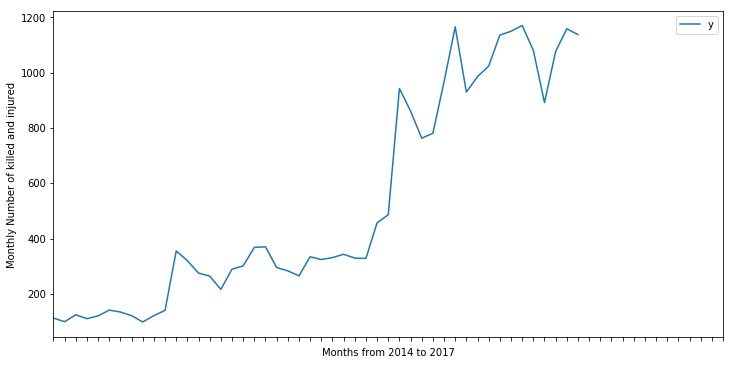

In [32]:
### Time Series 
time = pd.date_range('2014-01-01','2017-12-31',freq='MS').strftime("%Y-%m").tolist()
victim = pd.DataFrame({'ds':time,'y':num_killed})
ts = victim.set_index('ds').plot(figsize = (12,6))
ts.set_ylabel('Monthly Number of killed and injured ')
ts.set_xlabel('Months from 2014 to 2017')
plt.xlim([0,60])
plt.xticks(np.arange(0, 61, 1))
plt.show()

* The plot shown is just a time series plot of the incident count per month. It is clear that the number of incidents is steadily rising.

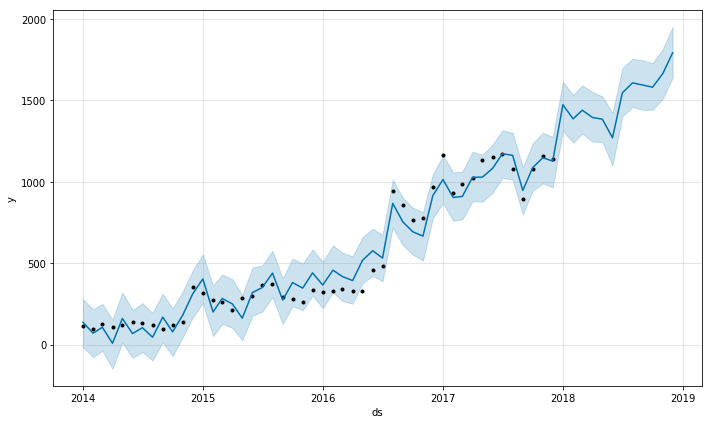

In [33]:
ts_model = Prophet(interval_width = 0.95,weekly_seasonality = True,daily_seasonality=True)
ts_model.fit(victim)
future = ts_model.make_future_dataframe(periods=12, freq='MS')
predic = ts_model.predict(future)
predic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig1 = ts_model.plot(predic)

* The plot above is a time series plot of the counts of incidents per month from 2014 to the end of 2017. We created a model to predict the counts of incidents per month for 2018. The shaded blue areas are the 95% confidence intervals for the time series plot. 

## Conclusion

* We found that majority of suspects are males.
* The states with the most amount of homicides are California, Texas, and Illinois.
* The most popular firearms is handgun.
* The average age of suspects is around 18-19.
* Using either forward or backward method, the model using all the features, it has the smallest value of AIC and BIC and highest R-squared. 
* The prediction model underestimates the first quarter for injured and killed.
* The prediction points are within the prediction interval except one case.


## Challenges
* There were many challenges in this project. When we created the linear regression model, the data was transformed using a cube root, although we were able to find a transformation, we could have found a better model transformation.
* One of the challenges we faced working on this project is the training and testing data sets have a left-skewed distribution which meant the data points were concentrated in a certain area.
* The data required a lot of cleaning. We had to figure out unique ways to manipulate the data into workable data.